In [1]:
import pynsx as nsx
import math
import numpy as np
from matplotlib import pyplot as plt
from os import path
import glob

In [2]:
def plot_I_vs_q(peak_list):
    qs = []
    Is = []
    
    for peak in peak_list:
        q = np.linalg.norm(peak.getQ().rowVector())
        I = peak.getCorrectedIntensity().value()
        qs.append(q)
        Is.append(I)
    
    plt.figure(figsize=(10,10))
    plt.scatter(qs, Is)
    plt.show()
    
def plot_Isigma_vs_q(peak_list):
    qs = []
    Is = []
    
    for peak in peak_list:
        q = np.linalg.norm(peak.getQ().rowVector())
        I = peak.getCorrectedIntensity().value()
        sigma = peak.getCorrectedIntensity().sigma()
        qs.append(q)
        Is.append(I/sigma)
    
    plt.figure(figsize=(10,10))
    plt.scatter(qs, Is)
    plt.show()    
    
def plot_dq_vs_frame(peak_list):
    dqs = []
    frames = []
    
    for i in range(len(peak_list)):
        peak = peak_list[i]
        obs_q = peak.getQ().rowVector()
        uc = peak.activeUnitCell()
        bu = uc.reciprocalBasis()
        hkl = uc.getIntegerMillerIndices(peak.getQ()).rowVector()
        pred_q = hkl.dot(bu)
        assert(pred_q.shape == obs_q.shape)
        dq = np.linalg.norm(pred_q-obs_q)
        
        dqs.append(dq)
        frames.append(peak.getShape().center()[2])
        
    plt.figure(figsize=(10,10))
    plt.scatter(frames, dqs)
    plt.show()
    
def plot_dx_vs_frame(peak_list, outlier=20):
    dxs = []
    frames = []
    
    for i in range(len(peak_list)):
        peak = peak_list[i]
        obs_x = peak.getShape().center()
        uc = peak.activeUnitCell()
        bu = uc.reciprocalBasis()
        hkl = uc.getIntegerMillerIndices(peak.getQ()).rowVector()
        pred_q = hkl.dot(bu)
        
        predictor = nsx.PeakPredictor(peak.data())
        ellipsoid = nsx.Ellipsoid(pred_q.transpose(), 100.0*np.identity(3)) 
        
        #hkls = nsx.MillerIndexList()
        #hkls.push_back()
  
        #print(hkl)
        preds = predictor.predictPeaks([nsx.MillerIndex(int(hkl[0,0]), int(hkl[0,1]), int(hkl[0,2]))], uc.reciprocalBasis())
            
        if len(preds) != 1:
            peak.setSelected(False)
            continue
            
        dx = np.linalg.norm(obs_x - preds[0].getShape().center())
        
        if (dx > outlier):
            peak.setSelected(False)
            continue
        
        dxs.append(dx)
        frames.append(peak.getShape().center()[2])

        
    print("npred", len(dxs))
    plt.figure(figsize=(10,10))
    plt.scatter(frames, dxs)
    plt.show()
    
def find_batch(peak, batches):
    z = peak.getShape().center()[2,0]
    
    for b in batches:
        if b.contains(z):
            return b
        
    return None
    
def reindex(peak_list, batches):          
    new_peaks = []
    
    for peak in peak_list:
        
        batch = find_batch(peak, batches)
        
        if batch is None:
            continue
        
        hkl = np.array([[0.,0.,0.]])
        uc = batch.cell()
        
        if uc.getMillerIndices(peak.getQ(), hkl):
            peak.addUnitCell(uc, True)
            new_peaks.append(peak)
            
    return new_peaks

def compute_statistics(peak_list, group, friedel):
    merged = nsx.MergedData(group, friedel)
    for peak in peak_list:
        if peak.isSelected():
            merged.addPeak(peak)
            
    r = nsx.RFactor()
    cc = nsx.CC()
    
    r.calculate(merged)
    cc.calculate(merged)
    
    stats = {}
    stats['CChalf'] = cc.CChalf()
    stats['CCtrue'] = cc.CCstar()
    stats['Rmeas'] = r.Rmeas()
    stats['Rmerge'] = r.Rmerge()
    stats['Rpim'] = r.Rpim()
    
    return stats

def num_selected_peaks(peaks):
    num_selected = 0
    
    for peak in peaks:
        if peak.isSelected():
            num_selected += 1
            
    return num_selected
    
def filter_peaks(peaks):
    for peak in peaks:
        if not peak.isSelected():
            continue
            
        if peak.pValue() > 1e-3:
            peak.setSelected(False)
            continue
            
        d = 1.0 / np.linalg.norm(peak.getQ())
        
        if d > 50.0 or d < 2.1:
            peak.setSelected(False)
            continue
            
        profile = nsx.Profile()
        
        if profile.fit(peak.getIntegration().getProjectionPeak()) == False:
            peak.setSelected(False)
            continue
        
def remove_deselected(data):
    peaks = data.getPeaks()
    
    for peak in peaks:
        if not peak.isSelected():
            data.removePeak(peak)

In [3]:
expt = nsx.Experiment('test', 'D19')
diff = expt.getDiffractometer()

data_dir = path.expanduser("~/data/d19_data/rubredoxin/y-corrected-data/")
data_files = glob.glob(data_dir + "*.h5")

numors = []

for f in data_files:
    reader = nsx.HDF5DataReader(f,diff)
    # Discard the data with a low number of frames (unlikely to be "production" data)
    if (reader.getNFrames() < 50):
        continue

    # Build the dataset
    data = nsx.DataSet(reader,diff)

    # Add the data to the experiment
    expt.addData(data)

    numors.append(data)
    
print(len(numors))

43


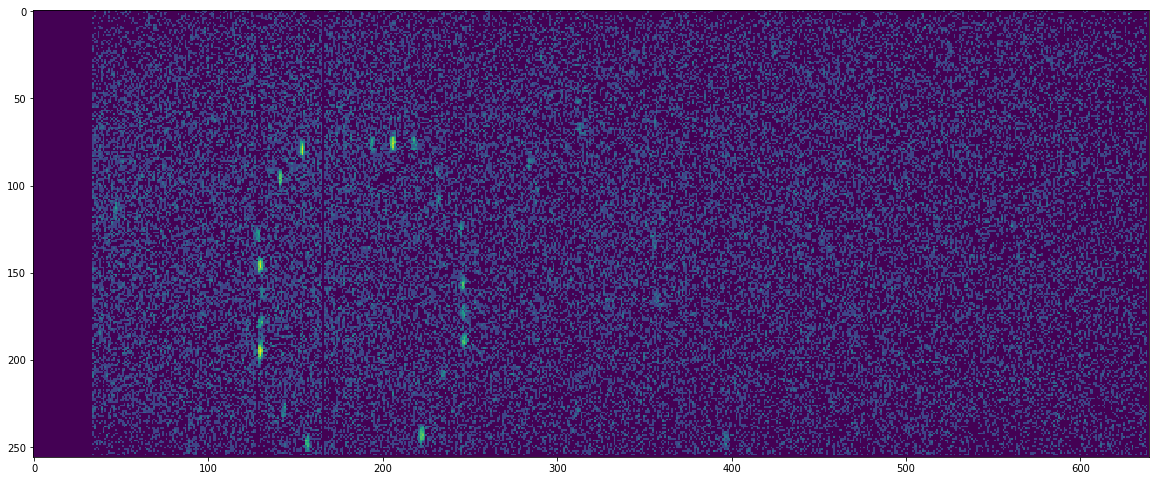

In [4]:
plt.figure(figsize=(20,10))
plt.imshow(np.log(1+numors[0].frame(0)))
plt.show()

nrows = numors[0].nRows()
ncols = numors[0].nCols()

In [5]:
kernel = nsx.AnnularKernel(nrows, ncols)
kernel_image = kernel.getKernel()
convolver = nsx.Convolver()
convolver.setKernel(kernel_image)

In [12]:
finder = nsx.PeakFinder()
finder.setConvolver(convolver)
finder.setMinComponents(30)
finder.setMaxComponents(10000)
finder.setIntegrationConfidence(0.98)
finder.setSearchConfidence(0.67)
finder.setThresholdType(1)
finder.setThresholdValue(10.0)
finder.setKernel(kernel)

In [13]:
num_numors = len(numors)
peaks = finder.find(numors)
print(peaks.size())
len(numors)

8310


43

In [17]:
for peak in peaks:
       
    inten = peak.getCorrectedIntensity()
    
    if not peak.isSelected():
        continue
    
    if (inten.sigma() < 1.0):
        peak.setSelected(False)
        
    if (inten.value() / inten.sigma() < 1.0):
        peak.setSelected(False)

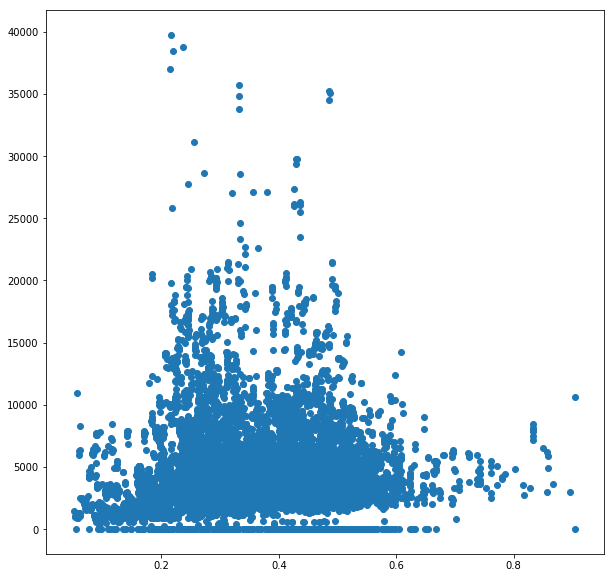

In [18]:
plot_I_vs_q(peaks)

7693


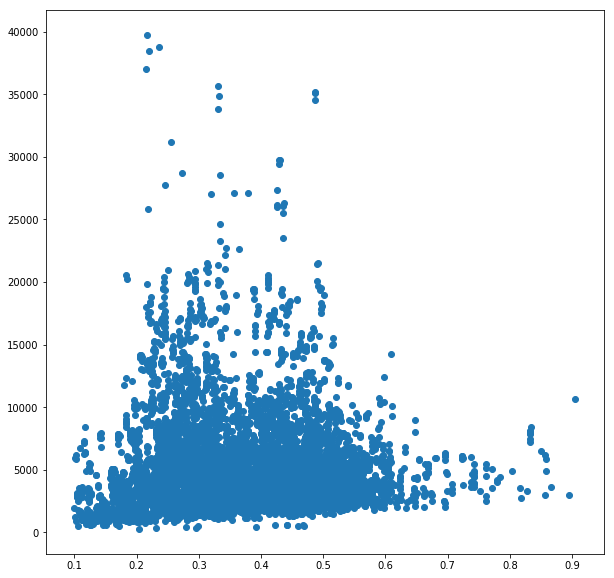

In [19]:
# clean up peaks
good_peaks = []

for peak in peaks:
    I = peak.getCorrectedIntensity().value()
    sigma = peak.getCorrectedIntensity().sigma()
    
    # keep only selected peaks
    if not peak.isSelected():
        continue
    
    # keep only strong peaks for autoindex
    if I < 1.0*sigma:
        continue
        
    d = 1.0 / np.linalg.norm(peak.getQ().rowVector())
    
    # keep peaks only in specified d range
    if d > 10.0 or d < 0.88:
        continue
        
    good_peaks.append(peak)
    
print(len(good_peaks))
plot_I_vs_q(good_peaks)

In [20]:
####################################
# AUTO-INDEXING
####################################

indexer = nsx.AutoIndexer(nsx.ProgressHandler())

for peak in good_peaks:
    indexer.addPeak(peak)

params = nsx.IndexerParameters()
indexer.autoIndex(params)

solutions = indexer.getSolutions()

cell_parameters = []

for idx, (uc,score) in enumerate(solutions):

    a     = uc.character().a
    b     = uc.character().b
    c     = uc.character().c
    alpha = np.rad2deg(uc.character().alpha)
    beta  = np.rad2deg(uc.character().beta)
    gamma = np.rad2deg(uc.character().gamma)

    cell_parameters.append((idx,a,b,c,alpha,beta,gamma,score))

    print("idx: {0:3d} --- a = {1:6.2f}  b = {2:6.2f}  c = {3:6.2f}  alpha = {4:6.2f}  beta = {5:6.2f}  gamma = {6:6.2f} --- % indexed = {7:5.2f}".format(*(cell_parameters[-1])))


idx:   0 --- a =  34.17  b =  35.13  c =  43.64  alpha =  90.00  beta =  90.00  gamma =  90.00 --- % indexed = 97.17
idx:   1 --- a =  87.23  b =  70.31  c =  34.17  alpha =  90.00  beta =  90.00  gamma =  90.00 --- % indexed = 52.85
idx:   2 --- a =  48.94  b =  48.94  c =  87.23  alpha =  90.00  beta =  90.00  gamma =  90.00 --- % indexed = 49.32
idx:   3 --- a =  34.97  b =   0.02  c =  40.18  alpha =  90.00  beta =  90.43  gamma =  90.00 --- % indexed = 39.96
idx:   4 --- a =  34.98  b =   0.02  c =  39.79  alpha =  90.00  beta =  91.11  gamma =  90.00 --- % indexed = 39.62
idx:   5 --- a =  34.07  b =   0.03  c = 123.54  alpha =  90.00  beta =  92.08  gamma =  90.00 --- % indexed = 39.61
idx:   6 --- a =  34.06  b =   0.66  c =  52.06  alpha =  90.00  beta =  90.66  gamma =  90.00 --- % indexed = 35.79
idx:   7 --- a =  48.95  b =  55.16  c =  87.57  alpha =  84.86  beta =  75.33  gamma =  64.14 --- % indexed = 35.63
idx:   8 --- a =  32.30  b =  34.92  c =  43.84  alpha =  89.71 

In [21]:
# take best unit cell
uc = solutions[0][0]

for peak in good_peaks:
    peak.addUnitCell(uc, True)

In [22]:
####################################
# SPACE-GROUP
####################################

compatible_space_groups = uc.compatibleSpaceGroups()

hkls = nsx.MillerIndexList()

for peak in good_peaks:
    hkls.push_back(uc.getIntegerMillerIndices(peak.getQ()))

space_groups = []
for idx,symbol in enumerate(compatible_space_groups):
    sg = nsx.SpaceGroup(symbol)
    space_groups.append((idx,symbol,100.0*(1.0-sg.fractionExtinct(hkls))))
    print("idx: {0:3d} --- symbol = {1:10s}  --- % non-extincted peaks = {2:6.2f}".format(*(space_groups[-1])))

idx:   0 --- symbol = P 2 2 2     --- % non-extincted peaks = 100.00
idx:   1 --- symbol = P 2 2 21    --- % non-extincted peaks = 100.00
idx:   2 --- symbol = P 21 21 2   --- % non-extincted peaks = 100.00
idx:   3 --- symbol = P 21 21 21  --- % non-extincted peaks = 100.00
idx:   4 --- symbol = P m m 2     --- % non-extincted peaks = 100.00
idx:   5 --- symbol = P m c 21    --- % non-extincted peaks =  97.28
idx:   6 --- symbol = P c c 2     --- % non-extincted peaks =  94.53
idx:   7 --- symbol = P m a 2     --- % non-extincted peaks =  97.57
idx:   8 --- symbol = P c a 21    --- % non-extincted peaks =  94.81
idx:   9 --- symbol = P n c 2     --- % non-extincted peaks =  94.51
idx:  10 --- symbol = P m n 21    --- % non-extincted peaks =  97.95
idx:  11 --- symbol = P b a 2     --- % non-extincted peaks =  95.01
idx:  12 --- symbol = P n a 21    --- % non-extincted peaks =  94.80
idx:  13 --- symbol = P n n 2     --- % non-extincted peaks =  95.18
idx:  14 --- symbol = P m m m     

In [23]:
peak_set = nsx.PeakSet()

for peak in good_peaks:
    peak_set.insert(peak)

for data in numors:
    data.integratePeaks(peak_set, 5.0, 8.0, nsx.ProgressHandler())
    
compute_statistics(good_peaks, nsx.SpaceGroup("P 21 21 21"), True)

{'CChalf': 0.8948654403485072,
 'CCtrue': 0.9718621720721989,
 'Rmeas': 0.1679977704546258,
 'Rmerge': 0.15078375362444313,
 'Rpim': 0.0675389738154943}

In [25]:
#################
# Refinement
#################
refinements = []

for data in numors:
    print("Refining parameters for dataset", data.filename())
    nbatches = 1
    states = data.instrumentStates()
    
    # testing
    #B = uc.reciprocalBasis()
    #dB = np.random.rand(3,3) * 0.01 * np.linalg.norm(B)
    #uc.setReciprocalBasis(B+dB)
    
    data_peaks = []
    
    for peak in good_peaks:
        if peak.data().filename() == data.filename():
            data_peaks.append(peak)
            
    #print(len(data_peaks))
    
    refiner = nsx.Refiner(uc, data_peaks, nbatches)
    
    if (len(data_peaks) < 20):
        print("Too few peaks; skipping")
        continue
    
    #refiner.refineSamplePosition(states)
    #refiner.refineKi(states)
    #refiner.refineSampleOrientation(states)
    
    #refiner.refineU()
    refiner.refineB()
    
    success = refiner.refine(200)
    
    refinements.append([data, refiner, success])
    print("refinement successful:", success)
    
#refiner.refineU()
    


Refining parameters for dataset /home/jonathan/data/d19_data/rubredoxin/y-corrected-data/092828.h5
Too few peaks; skipping
Refining parameters for dataset /home/jonathan/data/d19_data/rubredoxin/y-corrected-data/092825.h5
refinement successful: True
Refining parameters for dataset /home/jonathan/data/d19_data/rubredoxin/y-corrected-data/092845.h5
Too few peaks; skipping
Refining parameters for dataset /home/jonathan/data/d19_data/rubredoxin/y-corrected-data/092854.h5
Too few peaks; skipping
Refining parameters for dataset /home/jonathan/data/d19_data/rubredoxin/y-corrected-data/092826.h5
refinement successful: True
Refining parameters for dataset /home/jonathan/data/d19_data/rubredoxin/y-corrected-data/092857.h5
Too few peaks; skipping
Refining parameters for dataset /home/jonathan/data/d19_data/rubredoxin/y-corrected-data/092820.h5
Too few peaks; skipping
Refining parameters for dataset /home/jonathan/data/d19_data/rubredoxin/y-corrected-data/092832.h5
Too few peaks; skipping
Refining

In [26]:
def predict_peaks(reference_peaks, data, dmin, dmax, B, batches):    
    pred = nsx.PeakPredictor(data)
    qshape = pred.averageQShape(reference_peaks)
    wavelength = data.diffractometer().source().getSelectedMonochromator().getWavelength()    
    hkls = uc.generateReflectionsInShell(dmin, dmax, wavelength)       
    prediction = pred.predictPeaks(hkls, B)
    
    good_pred = []
    
    for batch in batches:
        bcell = batch.cell()
        preds = pred.predictPeaks(hkls, bcell.reciprocalBasis())
        
        for p in preds:
            if not batch.contains(p.getShape().center()[2,0]):
                continue
                
            hkl = np.array([[0.,0.,0.]])
            
            if not bcell.getMillerIndices(p.getQ(), hkl):
                continue
                
            q = hkl.dot(bcell.reciprocalBasis())
            shape = nsx.Ellipsoid(q.transpose(), qshape)
            try:
                shape = pred.toDetectorSpace(shape)
            except:
                continue
                
            p.setShape(shape)                
            p.addUnitCell(bcell, True)
            good_pred.append(p)
    
    return good_pred


In [27]:
predicted = []

for r in refinements:
    data, refiner, success = r
    preds = predict_peaks(good_peaks, data, 0.88, 50.0, uc.reciprocalBasis(), refiner.batches())
    print("Prediced", len(preds), "peaks")
    predicted.extend(preds)
    
print("Total predicted peaks:", len(predicted))

Prediced 2312 peaks
Prediced 610 peaks
Prediced 17010 peaks
Prediced 2267 peaks
Prediced 1647 peaks
Prediced 2178 peaks
Prediced 610 peaks
Prediced 603 peaks
Prediced 2304 peaks
Prediced 6731 peaks
Prediced 15023 peaks
Prediced 11658 peaks
Prediced 2301 peaks
Prediced 5674 peaks
Prediced 16917 peaks
Prediced 1250 peaks
Prediced 10275 peaks
Total predicted peaks: 99370


In [30]:
peak_set = nsx.PeakSet()

for peak in predicted:
    peak.setSelected(True)
    peak_set.insert(peak)

integrating /home/jonathan/data/d19_data/rubredoxin/y-corrected-data/092828.h5
integrating /home/jonathan/data/d19_data/rubredoxin/y-corrected-data/092825.h5
integrating /home/jonathan/data/d19_data/rubredoxin/y-corrected-data/092845.h5
integrating /home/jonathan/data/d19_data/rubredoxin/y-corrected-data/092854.h5
integrating /home/jonathan/data/d19_data/rubredoxin/y-corrected-data/092826.h5
integrating /home/jonathan/data/d19_data/rubredoxin/y-corrected-data/092857.h5
integrating /home/jonathan/data/d19_data/rubredoxin/y-corrected-data/092820.h5
integrating /home/jonathan/data/d19_data/rubredoxin/y-corrected-data/092832.h5
integrating /home/jonathan/data/d19_data/rubredoxin/y-corrected-data/092821.h5
integrating /home/jonathan/data/d19_data/rubredoxin/y-corrected-data/092823.h5
integrating /home/jonathan/data/d19_data/rubredoxin/y-corrected-data/092860.h5
integrating /home/jonathan/data/d19_data/rubredoxin/y-corrected-data/092863.h5
integrating /home/jonathan/data/d19_data/rubredoxin/

In [32]:
for data in numors:
    print("integrating", data.filename())
    data.integratePeaks(peak_set, 5.5, 10.0, nsx.ProgressHandler())
    
compute_statistics(predicted, nsx.SpaceGroup("P 21 21 21"), True)

{'CChalf': 0.9180685353383503,
 'CCtrue': 0.9784091125313458,
 'Rmeas': 0.30837270604016787,
 'Rmerge': 0.2589697405975361,
 'Rpim': 0.16039207977356784}

In [44]:
for data in numors:
    print("integrating", data.filename())
    data.integratePeaks(peak_set, 3.5, 6.5, nsx.ProgressHandler())
    
compute_statistics(predicted, nsx.SpaceGroup("P 21 21 21"), True)

integrating /home/jonathan/data/d19_data/rubredoxin/y-corrected-data/092828.h5
integrating /home/jonathan/data/d19_data/rubredoxin/y-corrected-data/092825.h5
integrating /home/jonathan/data/d19_data/rubredoxin/y-corrected-data/092845.h5
integrating /home/jonathan/data/d19_data/rubredoxin/y-corrected-data/092854.h5
integrating /home/jonathan/data/d19_data/rubredoxin/y-corrected-data/092826.h5
integrating /home/jonathan/data/d19_data/rubredoxin/y-corrected-data/092857.h5
integrating /home/jonathan/data/d19_data/rubredoxin/y-corrected-data/092820.h5
integrating /home/jonathan/data/d19_data/rubredoxin/y-corrected-data/092832.h5
integrating /home/jonathan/data/d19_data/rubredoxin/y-corrected-data/092821.h5
integrating /home/jonathan/data/d19_data/rubredoxin/y-corrected-data/092823.h5
integrating /home/jonathan/data/d19_data/rubredoxin/y-corrected-data/092860.h5
integrating /home/jonathan/data/d19_data/rubredoxin/y-corrected-data/092863.h5
integrating /home/jonathan/data/d19_data/rubredoxin/

{'CChalf': 0.9527224844905517,
 'CCtrue': 0.987820288538378,
 'Rmeas': 0.23107186261939336,
 'Rmerge': 0.1965258602592968,
 'Rpim': 0.11632239917707753}

In [49]:
for data in numors:
    print("integrating", data.filename())
    data.integratePeaks(peak_set, 3.0, 6.0, nsx.ProgressHandler())
    
compute_statistics(predicted, nsx.SpaceGroup("P 21 21 21"), True)

integrating /home/jonathan/data/d19_data/rubredoxin/y-corrected-data/092828.h5
integrating /home/jonathan/data/d19_data/rubredoxin/y-corrected-data/092825.h5
integrating /home/jonathan/data/d19_data/rubredoxin/y-corrected-data/092845.h5
integrating /home/jonathan/data/d19_data/rubredoxin/y-corrected-data/092854.h5
integrating /home/jonathan/data/d19_data/rubredoxin/y-corrected-data/092826.h5
integrating /home/jonathan/data/d19_data/rubredoxin/y-corrected-data/092857.h5
integrating /home/jonathan/data/d19_data/rubredoxin/y-corrected-data/092820.h5
integrating /home/jonathan/data/d19_data/rubredoxin/y-corrected-data/092832.h5
integrating /home/jonathan/data/d19_data/rubredoxin/y-corrected-data/092821.h5
integrating /home/jonathan/data/d19_data/rubredoxin/y-corrected-data/092823.h5
integrating /home/jonathan/data/d19_data/rubredoxin/y-corrected-data/092860.h5
integrating /home/jonathan/data/d19_data/rubredoxin/y-corrected-data/092863.h5
integrating /home/jonathan/data/d19_data/rubredoxin/

{'CChalf': 0.9474055641728535,
 'CCtrue': 0.9864038531926768,
 'Rmeas': 0.23885528152518717,
 'Rmerge': 0.20436489059342702,
 'Rpim': 0.11838670471605539}

In [45]:
nshells = 10
dmin = 0.88
dmax = 50.0

shells = nsx.ResolutionShell(dmin, dmax, nshells)
stats = []

for peak in predicted:
    shells.addPeak(peak)
    
for i in range(nshells):
    shell = shells.shell(i)
    stats.append(compute_statistics(shell, nsx.SpaceGroup("P 21 21 21"), True))
   
def print_stats():    
    print("   dmin     dmax     Rmeas    Rmerge   Rpim     CChalf   CCtrue")
    d = shells.getD()

    for i,s in enumerate(stats):
        
        fmt = "{0:8.3f} {1:8.3f} {2:8.3f} {3:8.3f} {4:8.3f} {5:8.3f} {6:8.3f}"
        print(fmt.format(d[i], d[i+1], s["Rmeas"], s["Rmerge"], s["Rpim"], s["CChalf"], s["CCtrue"]))
    
print_stats()

   dmin     dmax     Rmeas    Rmerge   Rpim     CChalf   CCtrue
   0.880    0.911    1.154    0.942    0.641    0.423    0.771
   0.911    0.948    1.040    0.847    0.582    0.452    0.789
   0.948    0.991    1.037    0.827    0.605    0.324    0.699
   0.991    1.043    0.883    0.705    0.516    0.493    0.813
   1.043    1.109    0.719    0.572    0.425    0.576    0.855
   1.109    1.194    0.588    0.469    0.347    0.639    0.883
   1.194    1.315    0.492    0.394    0.287    0.708    0.911
   1.315    1.505    0.377    0.306    0.215    0.808    0.945
   1.505    1.896    0.255    0.212    0.138    0.870    0.965
   1.896   50.000    0.151    0.135    0.063    0.960    0.990


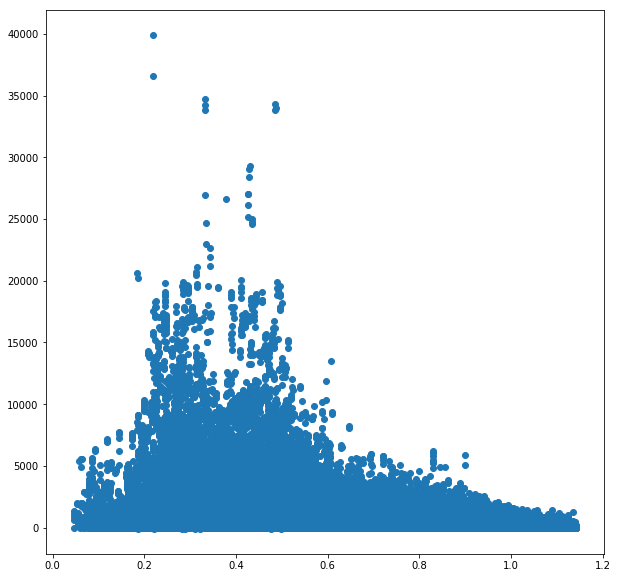

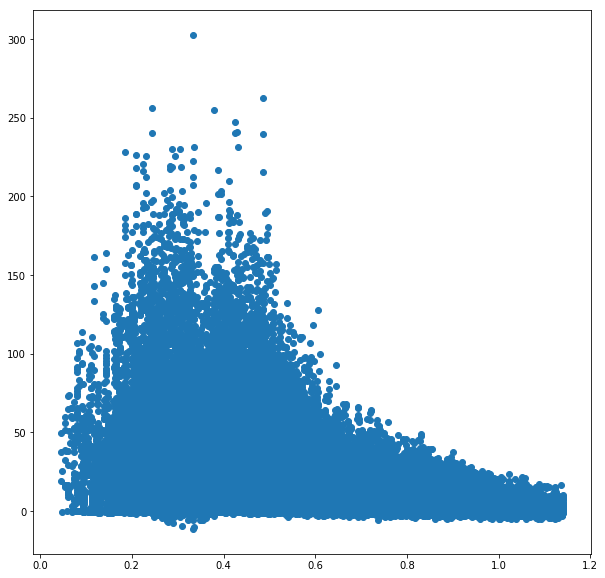

In [47]:
good_predicted = []
lors = []
qs = []

for p in predicted:
    inten = p.getCorrectedIntensity()
    
    state = p.data().interpolatedState(p.getShape().center()[2,0])
    qs.append(np.linalg.norm(p.getQ().rowVector()))
    
    # integration failure
    if inten.sigma() < 1.0:
        continue
        
    good_predicted.append(p)

plot_I_vs_q(good_predicted)
plot_Isigma_vs_q(good_predicted)


In [48]:
nshells = 20
dmin = 0.88
dmax = 26.9

shells = nsx.ResolutionShell(dmin, dmax, nshells)
stats = []

for peak in good_predicted:
    shells.addPeak(peak)
    
for i in range(nshells):
    shell = shells.shell(i)
    stats.append(compute_statistics(shell, nsx.SpaceGroup("P 21 21 21"), True))
       
def print_stats():    
    print(" n      dmin     dmax     Rmeas    Rmerge   Rpim     CChalf   CCtrue")
    d = shells.getD()

    for i,s in enumerate(stats):
        
        fmt = "{0:5d} {1:8.3f} {2:8.3f} {3:8.3f} {4:8.3f} {5:8.3f} {6:8.3f} {7:8.3f}"
        print(fmt.format(len(shells.shell(i)), d[i], d[i+1], s["Rmeas"], s["Rmerge"], s["Rpim"], s["CChalf"], s["CCtrue"]))
    
print_stats()

print("Total peaks", len(good_predicted))

 n      dmin     dmax     Rmeas    Rmerge   Rpim     CChalf   CCtrue
 3284    0.880    0.895    1.106    0.894    0.625    0.492    0.812
 3280    0.895    0.911    1.165    0.953    0.644    0.449    0.788
 3413    0.911    0.929    1.039    0.843    0.586    0.491    0.811
 3571    0.929    0.948    1.004    0.817    0.564    0.487    0.809
 3486    0.948    0.969    1.067    0.845    0.632    0.298    0.677
 3529    0.969    0.991    0.964    0.772    0.560    0.412    0.764
 3555    0.991    1.016    0.907    0.725    0.528    0.464    0.796
 3701    1.016    1.043    0.793    0.629    0.468    0.594    0.863
 3786    1.043    1.074    0.711    0.560    0.427    0.558    0.846
 3849    1.074    1.109    0.603    0.477    0.361    0.639    0.883
 3980    1.109    1.148    0.517    0.410    0.307    0.740    0.922
 4083    1.148    1.194    0.511    0.400    0.310    0.657    0.890
 4298    1.194    1.249    0.429    0.340    0.256    0.758    0.929
 4538    1.249    1.315    0.388  

In [40]:
d = []
for p in good_predicted:
    d.append(1.0 / np.linalg.norm(p.getQ().rowVector()))
    
print(min(d))
print(max(d))

0.876317407118817
26.82091427632414


In [23]:
bad_ex = None
good_ex = None

for peak in predicted:
    if not peak.isSelected():
        continue
        
    inten = peak.getCorrectedIntensity()
    sigma = inten.sigma()
    
    if bad_ex is None and sigma < 1.0:
        bad_ex = peak
        
    if good_ex is None and sigma > 100.0:
        good_ex = peak
        
    if not (bad_ex is None) and not (good_ex is None):
        break

In [24]:
print(bad_ex.getShape().center().transpose())
print()
print(bad_ex.getShape().metric())

[[594.71198013 203.64021195 477.07754402]]

[[ 0.6584799   0.01024104 -0.36422915]
 [ 0.01024104  0.20421119 -0.02064606]
 [-0.36422915 -0.02064606  0.25054007]]


In [25]:
print(good_ex.getShape().center().transpose())
print()
print(good_ex.getShape().metric())

[[617.01842975 146.18666262   8.11674371]]

[[ 0.59524797  0.00672564 -0.30603161]
 [ 0.00672564  0.21379281 -0.00661441]
 [-0.30603161 -0.00661441  0.20792051]]


In [26]:
print(np.sqrt(1.0 / np.linalg.eig(bad_ex.getShape().metric())[0]))
print(np.sqrt(1.0 / np.linalg.eig(good_ex.getShape().metric())[0]))

[1.07056405 5.26275508 2.21075042]
[1.14414999 5.0388628  2.16330559]


In [27]:
print(bad_ex.data().getFilename())

/home/jonathan/data/d19/reference_data/thom/y-corrected-data/125622.h5


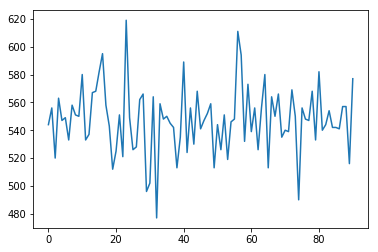

In [28]:
plt.plot(bad_ex.getProjection())
plt.show()

In [29]:
region = bad_ex.getIntegrationRegion()

In [39]:
peak.getBkgProjection()

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],

In [31]:
c = bad_ex.getShape().center()
state = bad_ex.data().getInterpolatedState(c[2,0])
pos = data.getDiffractometer().detector().pixelPosition(c[0,0], c[1,0])
factor = state.lorentzFactor(pos)

print(factor)

1.1429182406153953


In [32]:
region = bad_ex.getIntegrationRegion()

In [38]:
region = nsx.IntegrationRegion(bad_ex.getIntegrationRegion())
#help(region)
region.bestSlice()

3

In [34]:
print(good_ex.getCorrectedIntensity().sigma())
print(good_ex.getCorrectedIntensity().value())

122.96136321990903
6718.593211810288


In [35]:
help(bad_ex.getProfile())

Help on Profile in module pynsx object:

class Profile(builtins.object)
 |  Methods defined here:
 |  
 |  __del__ lambda self
 |  
 |  __getattr__ lambda self, name
 |  
 |  __init__(self, *args)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __repr__ = _swig_repr(self)
 |  
 |  __setattr__ lambda self, name, value
 |  
 |  __swig_destroy__ = delete_Profile(...)
 |  
 |  evaluate(self, x)
 |  
 |  fit(self, y, max_iter=100)
 |  
 |  goodFit(self, y, eps)
 |  
 |  integrate(self)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  __swig_getmethods__ = {}
 |  
 |  __swig_setmethods__ = {}



In [36]:
help(bad_ex.getIntegrationRegion())

Help on IntegrationRegion in module pynsx object:

class IntegrationRegion(builtins.object)
 |  Methods defined here:
 |  
 |  __del__ lambda self
 |  
 |  __getattr__ lambda self, name
 |  
 |  __init__(self, *args)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __repr__ = _swig_repr(self)
 |  
 |  __setattr__ lambda self, name, value
 |  
 |  __swig_destroy__ = delete_IntegrationRegion(...)
 |  
 |  aabb(self)
 |  
 |  bestSlice(self)
 |  
 |  classifySlice(self, p)
 |  
 |  nslices(self)
 |  
 |  setBestSlice(self, n)
 |  
 |  updateMask(self, mask, z)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  __sw